## **Laboratorio 5 - Data Science**
### *Autocodificadores*
Stefano Aragoni, Carol Arévalo

----------

#### **Parte 1**: Preparación de Datos

Como primer paso, se importan las librerías necesarias para el desarrollo del laboratorio.

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler

Posteriormente, se <font color=orange>cargaron los datos a un DataFrame de Pandas </font>.

En este caso se tienen 5 columnas;

1. La primera columna corresponde al nombre del producto.
2. Las siguientes 4 columnas corresponden al consumo, en gramos por persona por semana de diferentes comidas en cuatro países del Reino Unido

In [207]:
# Cargue los datos en un DataFrame de Pandas
data = pd.read_csv('UK_foods.csv')
data.columns = ['Food','England','Wales','Scotland','N.Ireland']

print(data.shape)

data.head(10)

(17, 5)


,Food,England,Wales,Scotland,N.Ireland
0,Cheese,105,103,103,66
1,Carcass_meat,245,227,242,267
2,Other_meat,685,803,750,586
3,Fish,147,160,122,93
4,Fats_and_oils,193,235,184,209
5,Sugars,156,175,147,139
6,Fresh_potatoes,720,874,566,1033
7,Fresh_Veg,253,265,171,143
8,Other_Veg,488,570,418,355
9,Processed_potatoes,198,203,220,187


Sin embargo, se realiza la transpuesta de los datos para que las columnas correspondan a los productos y las filas a los países. Esto para poder posteriormente reducir de 17 dimensiones a 2 dimensiones.

In [208]:
transposed_data = data.T

transposed_data.columns = transposed_data.iloc[0]
transposed_data = transposed_data[1:]
print(transposed_data.shape)
transposed_data = transposed_data.apply(pd.to_numeric, errors='coerce')
transposed_data.head(10)

(4, 17)


Food,Cheese,Carcass_meat,Other_meat,Fish,Fats_and_oils,Sugars,Fresh_potatoes,Fresh_Veg,Other_Veg,Processed_potatoes,Processed_Veg,Fresh_fruit,Cereals,Beverages,Soft_drinks,Alcoholic_drinks,Confectionery
England,105,245,685,147,193,156,720,253,488,198,360,1102,1472,57,1374,375,54
Wales,103,227,803,160,235,175,874,265,570,203,365,1137,1582,73,1256,475,64
Scotland,103,242,750,122,184,147,566,171,418,220,337,957,1462,53,1572,458,62
N.Ireland,66,267,586,93,209,139,1033,143,355,187,334,674,1494,47,1506,135,41


Con eso listo, se realizó una <font color=orange>exploración básica de los datos (estadísticas descriptivas)</font>.

Como primer paso, se observó si existían valores nulos o faltantes en el DataFrame, lo cual no fue el caso.

In [209]:
# Verificar si hay valores faltantes o nulos
missing_values = transposed_data.isnull().sum()
print("Valores faltantes o nulos por columna:")
print(missing_values)

Valores faltantes o nulos por columna:
Food
Cheese                 0
Carcass_meat           0
Other_meat             0
Fish                   0
Fats_and_oils          0
Sugars                 0
Fresh_potatoes         0
Fresh_Veg              0
Other_Veg              0
Processed_potatoes     0
Processed_Veg          0
Fresh_fruit            0
Cereals                0
Beverages              0
Soft_drinks            0
Alcoholic_drinks       0
Confectionery          0
dtype: int64


Posteriormente, se analizó la distribución de los datos. En este caso, son muy pocos datos por lo que no se puede realizar una buena visualización de la distribución de los datos.

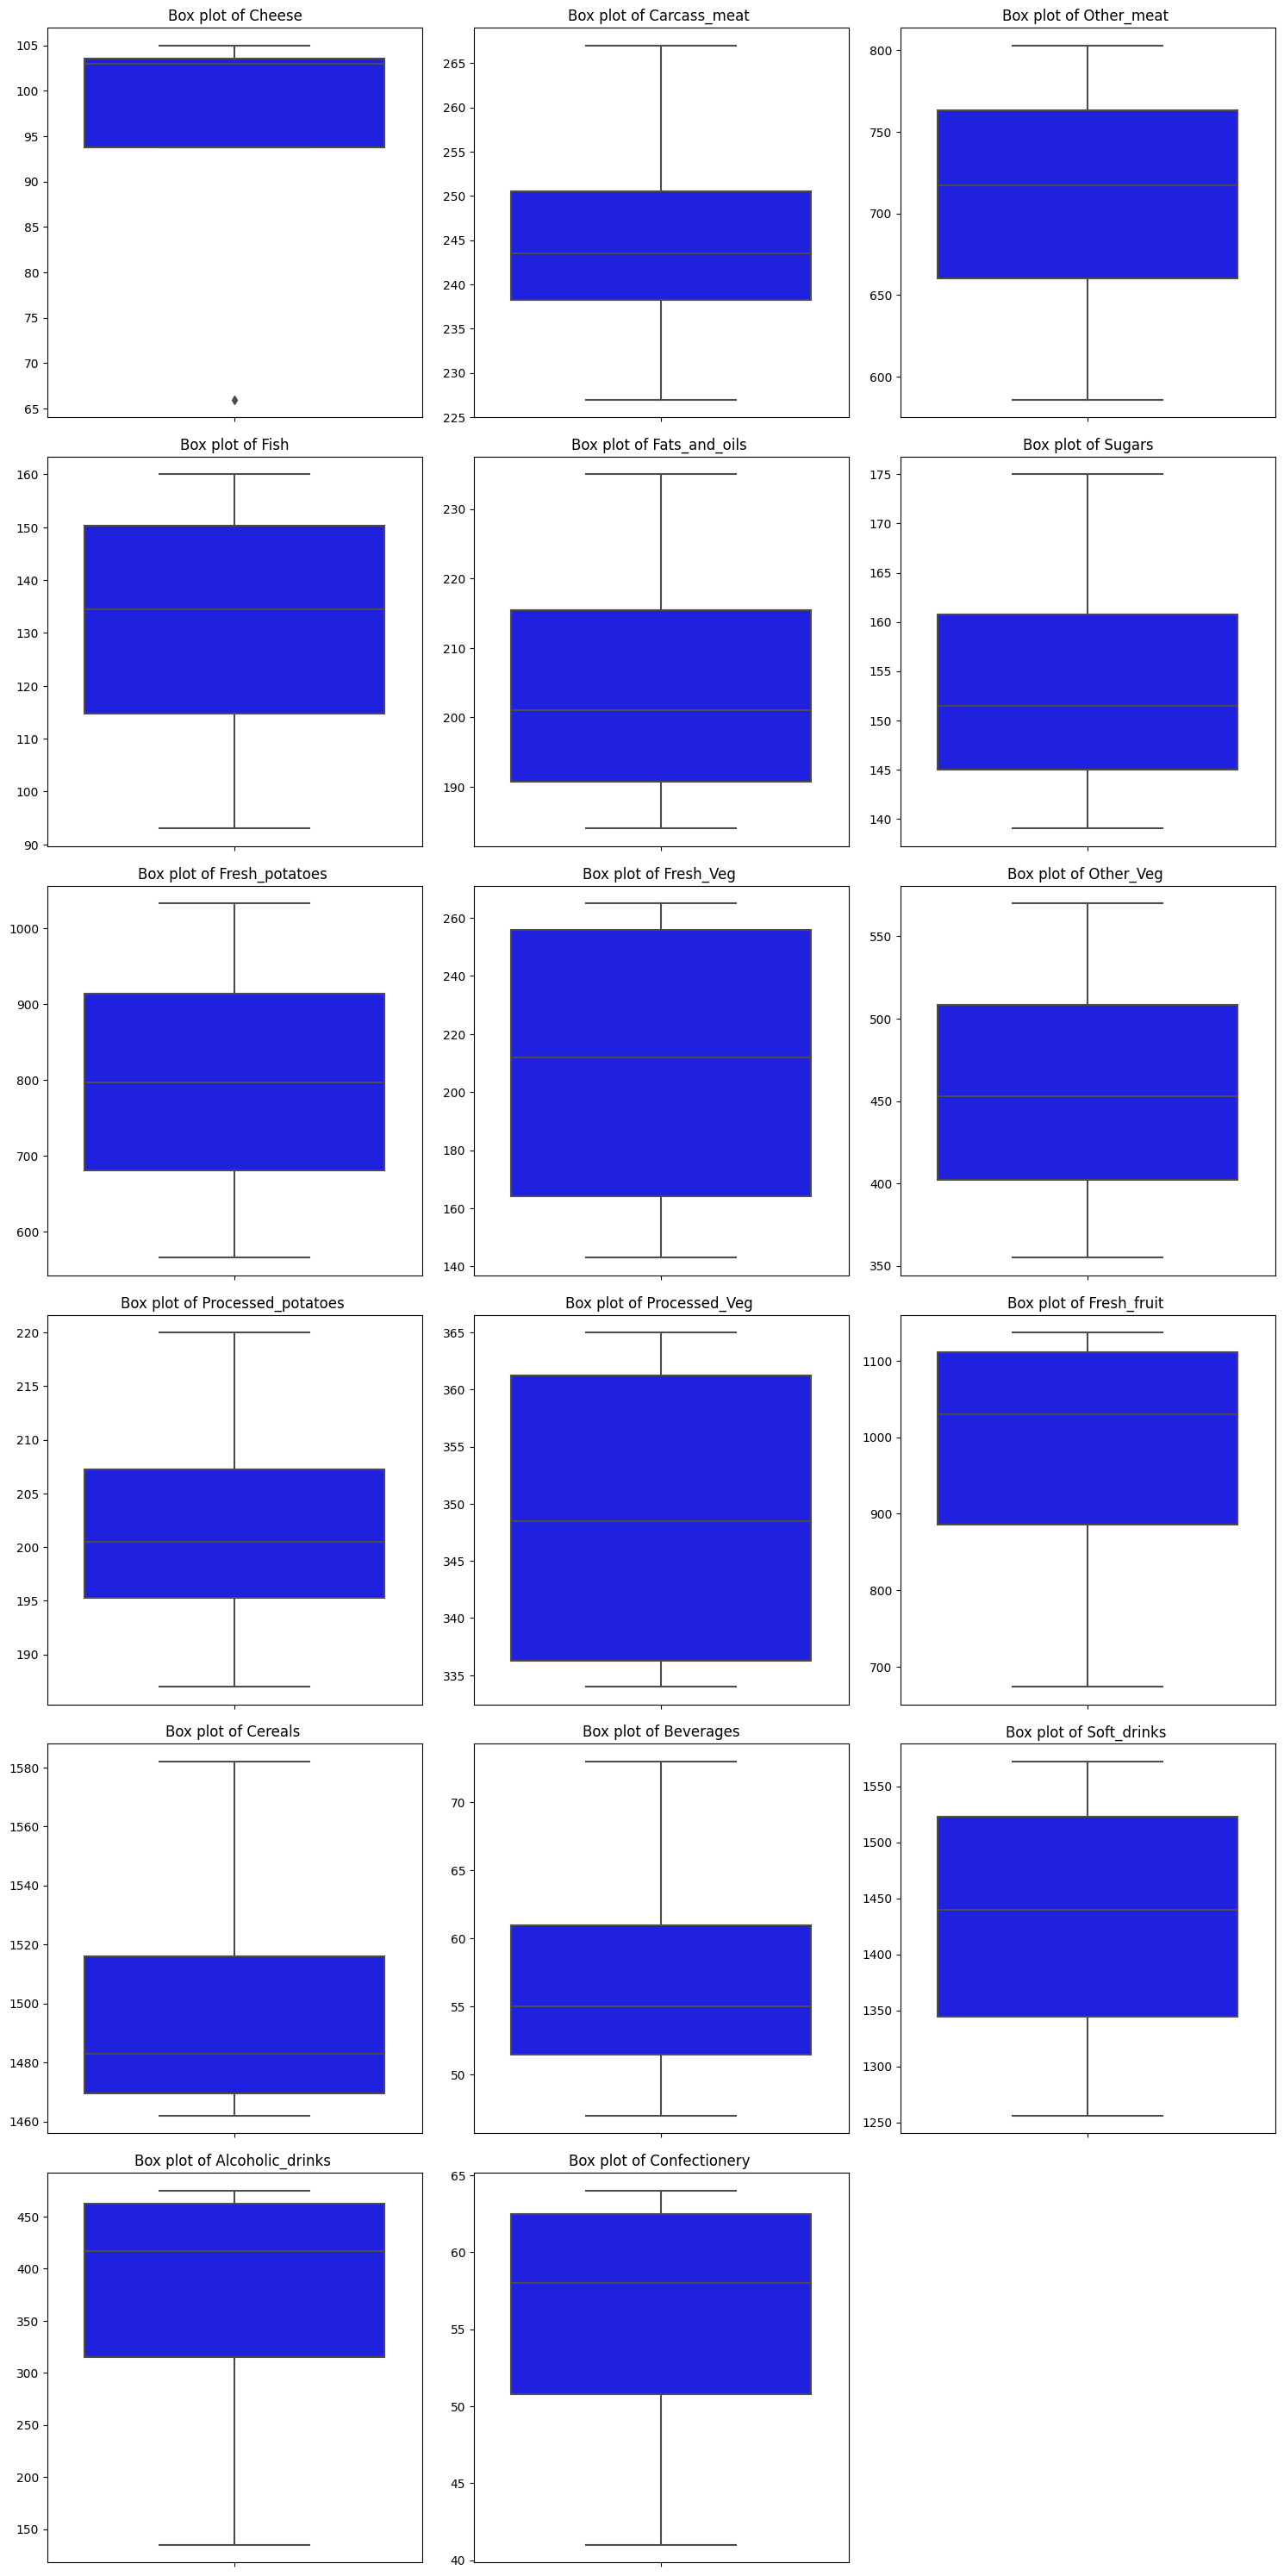

In [210]:
color = "#0000ff" 
num_cols = 3
num_rows = int(len(transposed_data.columns) / num_cols) + (len(transposed_data.columns) % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
axes = axes.ravel()  

for idx, col in enumerate(transposed_data.columns):
    sns.boxplot(y=transposed_data[col], ax=axes[idx], color=color)
    axes[idx].set_title(f"Box plot of {col}")
    axes[idx].set_ylabel('')

for j in range(idx+1, num_cols*num_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Asimismo, se realizó un análisis de *estadísticas descriptivas*. Sin embargo, los datos tienen una desviación estándar muy alta, lo cual indica que los datos están muy dispersos.

Esto indica que es necesario realizar una **normalización de los datos**, para que los valores de las columnas estén en un rango similar.

In [211]:
# Estadísticas descriptivas detalladas
numeric_data = transposed_data.select_dtypes(include=[np.number])

detailed_stats = transposed_data.describe(percentiles=[0.25, 0.5, 0.75])
print("Estadísticas descriptivas detalladas:")

detailed_stats

Estadísticas descriptivas detalladas:


Food,Cheese,Carcass_meat,Other_meat,Fish,Fats_and_oils,Sugars,Fresh_potatoes,Fresh_Veg,Other_Veg,Processed_potatoes,Processed_Veg,Fresh_fruit,Cereals,Beverages,Soft_drinks,Alcoholic_drinks,Confectionery
count,4.000000,4.00,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,94.250000,245.25,706.000000,130.500000,205.250000,154.25000,798.250000,208.000000,457.750000,202.000000,349.000000,967.500000,1502.500000,57.500000,1427.000000,360.750000,55.250000
std,18.856917,16.50,93.427334,29.557853,22.366269,15.47848,200.755863,60.188592,92.471167,13.735599,15.769168,210.612599,54.659552,11.120552,140.612944,156.712848,10.436315
min,66.000000,227.00,586.000000,93.000000,184.000000,139.00000,566.000000,143.000000,355.000000,187.000000,334.000000,674.000000,1462.000000,47.000000,1256.000000,135.000000,41.000000
25%,93.750000,238.25,660.250000,114.750000,190.750000,145.00000,681.500000,164.000000,402.250000,195.250000,336.250000,886.250000,1469.500000,51.500000,1344.500000,315.000000,50.750000
50%,103.000000,243.50,717.500000,134.500000,201.000000,151.50000,797.000000,212.000000,453.000000,200.500000,348.500000,1029.500000,1483.000000,55.000000,1440.000000,416.500000,58.000000
75%,103.500000,250.50,763.250000,150.250000,215.500000,160.75000,913.750000,256.000000,508.500000,207.250000,361.250000,1110.750000,1516.000000,61.000000,1522.500000,462.250000,62.500000
max,105.000000,267.00,803.000000,160.000000,235.000000,175.00000,1033.000000,265.000000,570.000000,220.000000,365.000000,1137.000000,1582.000000,73.000000,1572.000000,475.000000,64.000000


Finalmente, se realizó una <font color=orange>normalización de los datos</font>. En este caso se utilizó la función StandardScaler de la librería sklearn.

In [212]:
# Normalizar los datos
scaler = StandardScaler()
numeric_cols = transposed_data.columns

transposed_data[numeric_cols] = scaler.fit_transform(transposed_data[numeric_cols])
normalized_data = transposed_data[numeric_cols]

normalized_data.head(10)

Food,Cheese,Carcass_meat,Other_meat,Fish,Fats_and_oils,Sugars,Fresh_potatoes,Fresh_Veg,Other_Veg,Processed_potatoes,Processed_Veg,Fresh_fruit,Cereals,Beverages,Soft_drinks,Alcoholic_drinks,Confectionery
England,0.658275,-0.017495,-0.259546,0.644585,-0.632429,0.130551,-0.450076,0.863312,0.377736,-0.336265,0.805477,0.737407,-0.644322,-0.051917,-0.435231,0.104998,-0.138303
Wales,0.535805,-1.277169,1.198856,1.152440,1.535899,1.547958,0.435696,1.093528,1.401682,0.084066,1.171603,0.929297,1.679463,1.609440,-1.404236,0.841823,0.968122
Scotland,0.535805,-0.227441,0.543811,-0.332059,-1.097071,-0.540853,-1.335847,-0.709834,-0.496364,1.513193,-0.878702,-0.057567,-0.855575,-0.467257,1.190727,0.716563,0.746837
N.Ireland,-1.729885,1.522105,-1.483121,-1.464967,0.193601,-1.137656,1.350227,-1.247006,-1.283054,-1.260994,-1.098378,-1.609137,-0.179565,-1.090266,0.648741,-1.663384,-1.576656


#### **Parte 2**: Construcción del Autocodificador

Debido a que solo hay 4 datos (con 17 dimensiones) se decidió utilizar un <font color=orange>autocodificador lineal</font>. Asimismo, <font color=orange>se utilizaron todos los datos para el entrenamiento</font>.

In [213]:
X_train = normalized_data

A continuación se presenta <font color=orange>la definición de la arquitectura</font>. 

Más específicamente se utilizó una arquitectura secuencial. Esta red comienza con una capa de entrada de 17 nodos, que representa la dimensionalidad del conjunto de datos. Esta entrada se comprime gradualmente a través de capas densas que reducen la dimensionalidad primero a 8 nodos, luego a 4, y finalmente alcanzan el punto más estrecho de la arquitectura con solo 2 nodos. Este punto central representa la codificación bidimensional de los datos. A partir de ahí, la arquitectura se expande, pasando por capas de 4 y 8 nodos, para finalmente descomprimir y reconstruir los datos a su dimensionalidad original de 17 nodos. 

In [214]:
from keras.models import Sequential
from keras.layers import Dense

# Definir el modelo
autoencoder = Sequential([
    Dense(8, activation='relu', input_shape=(17,)),
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),  
    
    Dense(4, activation='relu'),
    Dense(8, activation='relu'),
    Dense(17, activation='linear') 
])

A continuación se <font color=orange>compila y entrena el modelo.</font> Como se puede observar, se tiene una pérdida de entrenamiento de 0.011526349000632763, lo cual indica que el modelo está aprendiendo correctamente. Cabe destacar que se uso 1,000 epochs debido a que solo hay 4 datos de entrenamiento.

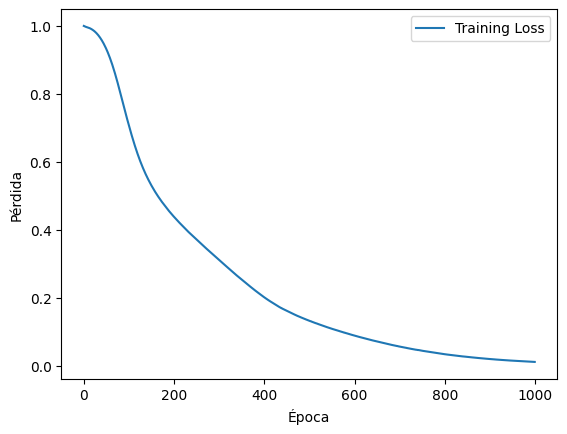

Pérdida en entrenamiento:  0.011526349000632763


In [215]:
# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo y evaluar en el conjunto de prueba en cada época
history = autoencoder.fit(
    X_train, X_train,
    epochs=1000,
    batch_size=32,
    verbose=0,
)

# Visualizar la pérdida en entrenamiento y prueba
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

print("Pérdida en entrenamiento: ", history.history['loss'][-1])


Posteriormente, <font color=orange>se evaluó el rendimiento del autocodificador (utilizando medidas como la pérdida de reconstrucción)</font>. 

Un error de reconstrucción de aproximadamente 0.011456349608132832 indica que el autoencoder está haciendo un buen trabajo al comprimir y luego descomprimir los datos, y la reconstrucción es bastante precisa en comparación con los datos originales. Asimismo el valor del MSE sugiere que la calidad de la reconstrucción es relativamente buena, pero aún hay margen de mejora. Un MAE de 0 indicaría una reconstrucción perfecta. En este caso, el MAE es de aproximadamente 0.07380933272472232. El MAE es un poco más alto que el MSE, lo que sugiere que algunos errores individuales pueden ser mayores, pero en promedio, los errores son relativamente bajos.

In [216]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Utilizar el autocodificador para reconstruir los datos del conjunto de prueba
reconstructed_data = autoencoder.predict(X_train)

# Calcular el error de reconstrucción (puedes usar la media del error cuadrado)
reconstruction_error = mean_squared_error(X_train, reconstructed_data)
print("Error de reconstrucción en el conjunto de prueba:", reconstruction_error)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(X_train, reconstructed_data)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(X_train, reconstructed_data)

# Calcular el coeficiente de determinación (R2)
r2 = r2_score(X_train, reconstructed_data)

# Imprimir las métricas
print("Error cuadrático medio (MSE):", mse)
print("Error absoluto medio (MAE):", mae)
print("Coeficiente de determinación (R2):", r2)

1/1 [==============================] - 0s 101ms/step
Error de reconstrucción en el conjunto de prueba: 0.011456349608132832
Error cuadrático medio (MSE): 0.011456349608132832
Error absoluto medio (MAE): 0.07380933272472232
Coeficiente de determinación (R2): 0.9885436503918671


#### **Parte 3**: Reducción de Dimensionalidad y Visualización 

Con el autocodificador listo, se logró <font color=orange>reducir las dimensiones del conjunto de datos a 2</font>. Para esto se utilizó el siguiente código.

In [217]:
# Utilizar el autocodificador para reducir las dimensiones del conjunto de datos a 2
encoder = Sequential(autoencoder.layers[:3])  # Obtén las primeras 3 capas del autoencoder
encoded_data = encoder.predict(X_train.iloc[:, :])

1/1 [==============================] - 0s 97ms/step


Finalmente, se <font color=orange> visualizaron las dos dimensiones en un gráfico de dispersión </font>.

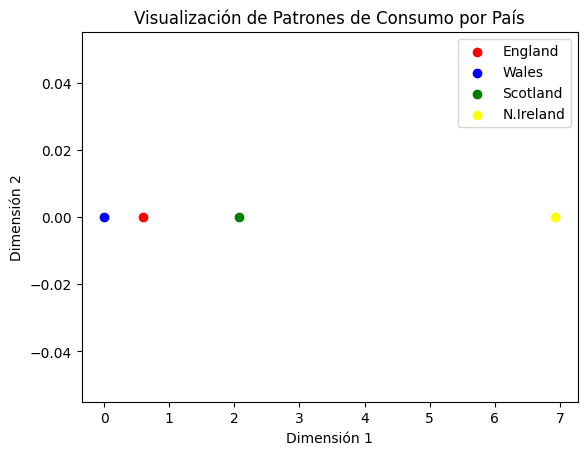

In [220]:
# Colores para cada país
colors = ['red', 'blue', 'green', 'yellow']
countries = ["England", "Wales", "Scotland", "N.Ireland"]

# Visualizar los datos en un gráfico de dispersión con colores
for i, country in enumerate(countries):
    plt.scatter(encoded_data[i, 0], encoded_data[i, 1], color=colors[i], label=country)

plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.title('Visualización de Patrones de Consumo por País')
plt.legend()
plt.show()

Finalmente, se realizó un <font color=orange>análisis para interpretar lo que representan estas dos nuevas dimensiones en relación con el
consumo de alimentos</font>. A continuación se presenta el análisis.

- En este caso, se puede observar que en el diagrama de dispersión England y Wales están muy cerca. Al observar el mapa del Reino Unido, se puede confirmar su proximidad geográfica. Asimismo, se puede observar que Escocia y Irlanda del Norte están más alejados. Geográficamente, Northen Ireland está totalmente separado de los otros países por el mar, por lo cual tiene sentido que este sea el país más alejado de los otros tres. En conclusión, **las dos nuevas dimensiones pueden estar capturando la proximidad geográfica de los países**.

- Al analizar el CSV, se puede observar que Northern Ireland difiere de gran manera en el consumo de alimentos a comparación de los otros países. Por ejemplo, este país consume más papas que los otros países. Asimismo, este consume mucho menos queso, fruta, y carne (pescado y otros) que los otros países. Esto podría ser un factor agricola, ya que Northern Ireland es un país más rural que los otros países. Asimismo, este país es conocido por su producción de papas. En conclusión, **las dos nuevas dimensiones pueden estar capturando la producción agrícola de los países**.

- Históricamente, Ireland ha tenido conflictos con el Reino Unido; incluso fue el último que se unió a este conjunto de países. Esto ha llevado a que este país tenga una cultura diferente a los otros. En conclusión, **las dos nuevas dimensiones pueden estar capturando la cultura de los países**. 

- En términos de población, Ireland tiene una población mucho menor que los otros países. Asimismo, tiene la menor área de los cuatro países. Esto podría ser un factor que influye en el consumo de alimentos. En conclusión, **las dos nuevas dimensiones pueden estar capturando la población y el área de los países**.

En resumen, existe un patrón de consumo similar entre Wales, Inglaterra y Scotland, mientras que N.Ireland tienen patrones de consumo más diferentes. Esto podría deberse a factores culturales, económicos, geográficos o históricos que influencian las dietas y preferencias alimenticias en cada país.

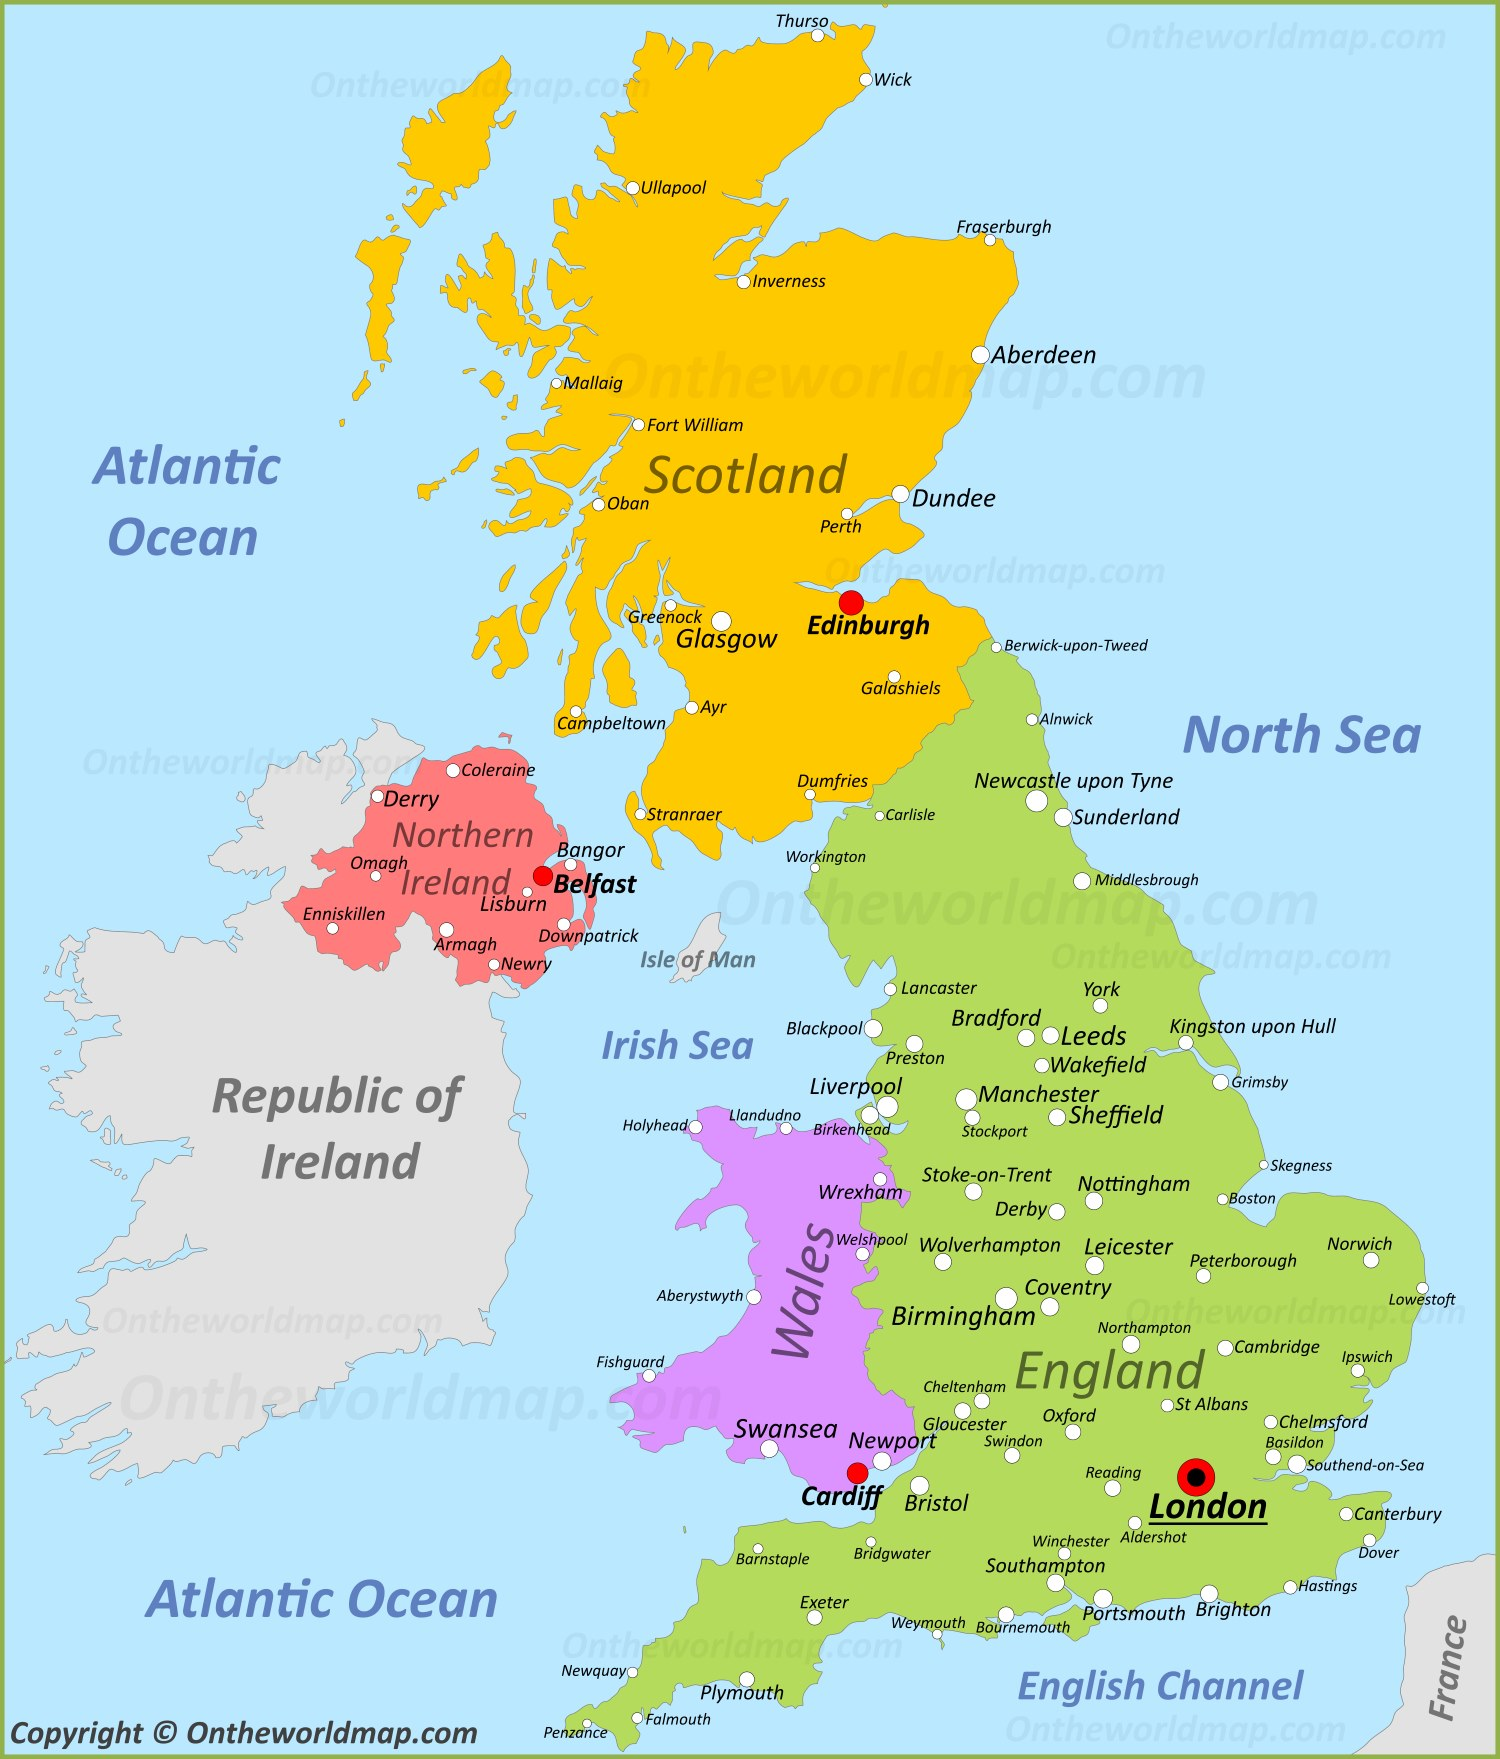

In [221]:
# Mostrar imágen united-kingdom-map-1500.jpg
from IPython.display import Image

Image(filename='united-kingdom-map-1500.jpg', width=600)

#### **Parte 4**: Discusión y percepciones nuevas "Insights" 



1. ¿Qué podemos aprender sobre los patrones de consumo de alimentos en los cuatro países del Reino Unido?

Histórica y económicamente, hay varias razones que podrían explicar las diferencias en los patrones de consumo entre los países del Reino Unido. Por ejemplo, según una investigación realizada, durante el siglo XX, N.Ireland experimentó conflictos significativos, conocidos como "The Troubles", que afectaron su economía. Se dice que debido a este conflicto, N.Ireland se quedó atrás en términos de desarrollo económico. Esto podría explicar por qué N.Ireland tiene un patrón de consumo diferente a los otros países. Los desafíos económicos y las tensiones podrían haber influido en los patrones de consumo de alimentos, haciendo que se diferencien de los otros países.

Asimismo, en términos de geografía y agricultura, Wales tradicionalmente ha sido una región de cría de ovejas y producción de lácteos. Por otro lado, Scotland es conocida por su producción de carne de res y whisky. Inglaterra tiene una diversidad de producciones agrícolas. N.Ireland es conocida por su producción de patatas y lácteos. Estas diferencias en la agricultura y la producción de alimentos podrían influir en los patrones de consumo.

Por otro lado, es importante las culturas y tradiciones de cada territorio, y como esto puede influir en los patrones de consumo. Por ejemplo, ciertos alimentos pueden ser más populares durante festividades locales o regionales. Esto especialmente considerando la ruralidad de los países.

En terminos geográficos, nuevamente, se puede mencionar la proximidad de los países. Por ejemplo, Inglaterra y Wales comparten una frontera, lo que podría influir en la similitud de sus patrones de consumo. Por otro lado, N.Ireland está separado de los otros países por el mar, lo que podría influir en sus diferencias en los patrones de consumo.

Referencia: https://en.wikipedia.org/wiki/United_Kingdom

2. ¿El autocodificador hizo un buen trabajo al reducir la dimensionalidad? ¿Qué métricas de rendimiento apoyan su afirmación?

Se puede concluir que el autocodificador hizo un buen trabajo al reducir la dimensionalidad. Esto debido a que logró, incluso, detectar la proximidad geográfica de los países. Esto está directamente relacionado con el consumo de alimentos, ya que los países que están más cerca geográficamente tienen un consumo de alimentos más similar.

Algunas métricas de rendimiento que apoyan esta afirmación son:

1. *Error de reconstrucción y MSE*: Son idénticos en este caso y son bastante bajos (0.011456349608132832). Un error de reconstrucción bajo indica que el autocodificador ha sido capaz de reconstruir los datos originales con precisión después de reducir su dimensionalidad.

2. *Error absoluto medio (MAE)*: El MAE de 0.07380933272472232 es una medida del error absoluto promedio entre los datos reconstruidos y los originales. En este caso, debido a que se normalizaron los datos entre 0 y 1, el MAE indica que hay un 7.38% de error en la reconstrucción de los datos originales.

3. *Coeficiente de determinación (R^2)*: El valor de 0.9885436503918671 es muy cercano a 1, lo cual indica que el autocodificador hecho un buen trabajo al retener la información esencial de los datos mientras reduce su dimensionalidad.

En resumen, basándonos en las métricas proporcionadas, podemos concluir que el autocodificador ha hecho un buen trabajo al reducir la dimensionalidad de los datos. El error de reconstrucción es bajo, el R^2 es alto, y el MAE es relativamente bajo. Estas métricas sugieren que el autocodificador ha sido capaz de retener la mayoría de la información de los datos originales en un espacio de dimensionalidad reducida.